In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
import numpy as np
import random
import math
import gym
import sys
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import csv
from collections import deque

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam

In [116]:
def formatPrice(n): #Print fomatted price
  return ("-$" if n < 0 else "$") + "{:0.2f}".format(abs(n))

def getStockDataVec(key): #returns stock data vector
  vec = []
  lines = open("data/" + key + ".txt", "r").read().splitlines()
  for line in lines[1:]:
    vec.append(float(line.split(",")[4]))

  return vec

def getStockVolVec(key): #returns stock volume vector
  vol = []
  lines = open("/content/drive/MyDrive/IDS576/Project/data/" + key + ".txt", "r").read().splitlines()
  for line in lines[1:]:
    vol.append(float(line.split(",")[5]))

  return vol

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [117]:
import numpy as np
import random
import math, random 
import gym 
import numpy as np 


class State:
    def __init__(self, data1, data2, Bal_stock1, Bal_stock2, open_cash, timestep):
        self.Stock1Price=data1[timestep] #stock 1 open price
        self.Stock2Price=data2[timestep] #stock 2 open price
        self.Stock1Blnc=Bal_stock1 #stock 1 balance
        self.Stock2Blnc=Bal_stock2 #stock 2 balance
        self.open_cash=open_cash #cash balance
        self.fiveday_stock1=self.five_day_window(data1, timestep)
        self.fiveday_stock2=self.five_day_window(data2, timestep)
        #self.volume1=volume1[timestep]
        #self.volume2=volume2[timestep]
        self.portfolio_value=self.portfolio_value()

    def portfolio_value(self):
        pvalue=0
        #print("In portfolio func")
        #print("self.Stock1Price",self.Stock1Price, type(self.Stock1Price))
        #print("self.Stock1Blnc",self.Stock1Blnc[0], type(self.Stock1Blnc))

        v1=self.Stock1Price * float(self.Stock1Blnc)
        v2=self.Stock2Price * float(self.Stock2Blnc)
        v3=(float(self.open_cash)/2)
        return (v1+v2+v3)
    
    def next_opening_price(self):
        return [data1[timestep+1], data2[timestep+1]]
    
    def five_day_window(self,data, timestep):
        step = timestep
        if step < 5:
            return data[0]
        
        stock_5days = np.mean(data[step-5:step])
        #print("stock_5days=" + str(stock_5days))
        #print(stock_5days)

        #print(type(stock_5days))

        return stock_5days
    
    def reset(self, data1, data2, Bal_stock1, Bal_stock2, open_cash, timestep):
        #self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.Stock1Price=data1[timestep] #stock 1 open price 
        self.Stock2Price=data2[timestep] #stock 2 open price 
        self.Stock1Blnc=Bal_stock1 #stock 1 balance 
        self.Stock2Blnc=Bal_stock2 #stock 2 balance 
        self.open_cash=open_cash #cash balance
        self.fiveday_stock1=self.five_day_window(data1, timestep)
        self.fiveday_stock2=self.five_day_window(data2, timestep)
        self.portfolio_value=10000
        
    def getState(self):
        #print("In get state")
        res=[]
        res.append(self.Stock1Price) #stock 1 open price
        res.append(self.Stock2Price) #stock 2 open price
        res.append(self.Stock1Blnc) #stock 1 balance
        res.append(self.Stock2Blnc) #stock 2 balance
        res.append(self.open_cash) #cash balance
        res.append(self.fiveday_stock1)
        res.append(self.fiveday_stock2)        
        res.append(self.portfolio_value)
        #res.append(self.volume1)
        #res.append(self.volume2)


        
        #print(res)
        res1=np.array([res])
        #print("res array"+np.array([res]))
        return res1

In [118]:
class Agent:
  def __init__(self, state_size, is_eval=False, model_name=""):
    self.state_size = state_size
    self.action_size = 5 #buy1, sell1, buy2, sell2, do nothing.
    self.memory = deque(maxlen=2000)
    self.inventory1 = []
    self.inventory2 = []
    self.model_name = model_name
    self.is_eval = is_eval
    self.gamma = 0.95 #discount factor (quantifies how much importance to give future rewards)
    self.epsilon = 1.0 #Eploration and Exploitation
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.model = load_model("/content/drive/MyDrive/IDS576/Project/models/" + model_name) if is_eval else self._model()
  
  def _model(self):
    model = Sequential()
    model.add(Dense(units=64, input_dim=self.state_size, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(self.action_size, activation='linear'))
    model.compile(loss="mse", optimizer=Adam(lr=0.0001))
    return model
  
  def act(self, state):
    if not self.is_eval and random.random() <= self.epsilon:
      return random.randrange(self.action_size)
    options = self.model.predict(state)
    return np.argmax(options[0])

  def expReplay(self, batch_size):
    mini_batch = []
    l = len(self.memory)

    minibatch = random.sample(self.memory, batch_size)

    for state, action, reward, next_state, done in mini_batch:
      target = reward

      if not done:
        target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
      
      target_f = self.model.predict(state)
      target_f[0][action] = target
      self.model.fit(state, target_f, epochs=1, verbose=0)
    
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay

In [119]:
stock_name1, stock_name2, episode_count, start_balance, training, test = 'aapl.us', 'amzn.us', 51, 10000, 1500, 500

In [120]:
pd_data1 = pd.read_csv('/content/drive/MyDrive/IDS576/Project/data/aapl.us.txt', sep=",", header=0)
pd_data2 = pd.read_csv('/content/drive/MyDrive/IDS576/Project/data/amzn.us.txt', sep=",", header=0)

In [121]:
pd_data1.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [122]:
pd_data1['Date']=pd.to_datetime(pd_data1['Date'], format='%Y/%m/%d')
pd_data2['Date']=pd.to_datetime(pd_data2['Date'], format='%Y/%m/%d')

In [123]:
pd_data1.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [124]:
pd_data2.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0


In [125]:
pd_data1.describe()

,Open,High,Low,Close,Volume,OpenInt
count,8364.000000,8364.000000,8364.000000,8364.000000,8.364000e+03,8364.0
mean,22.284350,22.495867,22.054244,22.281018,1.066416e+08,0.0
std,37.763402,38.057733,37.447432,37.764469,9.935187e+07,0.0
min,0.233050,0.235640,0.230510,0.230510,0.000000e+00,0.0
25%,1.137100,1.164200,1.112800,1.137100,4.384365e+07,0.0
50%,1.632800,1.663400,1.600600,1.628250,7.481383e+07,0.0
75%,23.739000,23.930500,23.335750,23.694500,1.320534e+08,0.0
max,175.110000,175.610000,174.270000,175.610000,2.069770e+09,0.0


In [126]:
pd_data2['Date'][0]

Timestamp('1997-05-16 00:00:00')

In [127]:
if (pd_data1['Date'][0] > pd_data2['Date'][0]):
  print("pd_data1 is older")
  pd_data1 = pd_data1[pd_data1.Date>=pd_data2['Date'][0]]
  pd_data1 = pd_data1.reset_index(drop=True)
else:
  print("pd_data1 is not older")
  pd_data2 = pd_data2[pd_data2.Date>=pd_data1['Date'][0]]
  pd_data2 = pd_data2.reset_index(drop=True)

pd_data1 is not older


In [128]:
pd_data1.describe()

,Open,High,Low,Close,Volume,OpenInt
count,8364.000000,8364.000000,8364.000000,8364.000000,8.364000e+03,8364.0
mean,22.284350,22.495867,22.054244,22.281018,1.066416e+08,0.0
std,37.763402,38.057733,37.447432,37.764469,9.935187e+07,0.0
min,0.233050,0.235640,0.230510,0.230510,0.000000e+00,0.0
25%,1.137100,1.164200,1.112800,1.137100,4.384365e+07,0.0
50%,1.632800,1.663400,1.600600,1.628250,7.481383e+07,0.0
75%,23.739000,23.930500,23.335750,23.694500,1.320534e+08,0.0
max,175.110000,175.610000,174.270000,175.610000,2.069770e+09,0.0


In [129]:
pd_data2.describe()

,Open,High,Low,Close,Volume,OpenInt
count,5153.000000,5153.000000,5153.000000,5153.000000,5.153000e+03,5153.0
mean,181.747357,183.880652,179.466684,181.769343,7.837325e+06,0.0
std,239.611052,241.226109,237.638139,239.548391,7.594745e+06,0.0
min,1.410000,1.450000,1.310000,1.400000,0.000000e+00,0.0
25%,35.500000,36.130000,35.000000,35.550000,3.779449e+06,0.0
50%,70.900000,72.750000,69.020000,70.700000,5.902992e+06,0.0
75%,242.850000,245.770000,240.670000,243.880000,8.888949e+06,0.0
max,1126.100000,1135.540000,1124.060000,1132.880000,1.043288e+08,0.0


In [130]:
import datetime
list1 = pd_data1['Date']
list2 = pd_data2['Date']
diff_pd1_data = list(set(list1) - set(list2))
diff_pd2_data = list(set(list2) - set(list1))
for k in range(len(diff_pd1_data)):
  pd1_date_format = diff_pd1_data[k].strftime('%Y-%m-%d 00:00:00')
  date_format_pd1 = datetime.datetime.strptime(pd1_date_format, '%Y-%m-%d 00:00:00')
  for i,j in enumerate(list1):
    if j == date_format_pd1:
      pd_data1 = pd_data1.drop([i])
pd_data1 = pd_data1.reset_index(drop=True)

for k in range(len(diff_pd2_data)):
  pd2_date_format = diff_pd2_data[k].strftime('%Y-%m-%d 00:00:00')
  date_format_pd2 = datetime.datetime.strptime(pd2_date_format, '%Y-%m-%d 00:00:00')
  for l,m in enumerate(list2):
    if m == date_format_pd2:
      pd_data2 = pd_data2.drop([l])
pd_data2 = pd_data2.reset_index(drop=True)

In [131]:
pd_data1.describe()

,Open,High,Low,Close,Volume,OpenInt
count,5151.000000,5151.000000,5151.000000,5151.000000,5.151000e+03,5151.0
mean,35.484689,35.816124,35.123519,35.479585,1.367661e+08,0.0
std,43.150378,43.473086,42.805762,43.153299,1.119530e+08,0.0
min,0.412350,0.423880,0.408530,0.413660,0.000000e+00,0.0
25%,1.518700,1.552100,1.488200,1.521300,6.327315e+07,0.0
50%,12.362000,12.710000,12.060000,12.403000,1.075093e+08,0.0
75%,64.097000,64.834000,63.631500,64.308500,1.764941e+08,0.0
max,175.110000,175.610000,174.270000,175.610000,2.069770e+09,0.0


In [132]:
pd_data2.describe()

,Open,High,Low,Close,Volume,OpenInt
count,5151.000000,5151.000000,5151.000000,5151.000000,5.151000e+03,5151.0
mean,181.812687,183.946772,179.531361,181.834821,7.835138e+06,0.0
std,239.634626,241.249596,237.661600,239.571842,7.594587e+06,0.0
min,1.410000,1.450000,1.310000,1.400000,0.000000e+00,0.0
25%,35.500000,36.230000,35.010000,35.580000,3.777334e+06,0.0
50%,70.940000,72.810000,69.020000,70.730000,5.901100e+06,0.0
75%,243.035000,246.240000,241.015000,243.900000,8.888874e+06,0.0
max,1126.100000,1135.540000,1124.060000,1132.880000,1.043288e+08,0.0


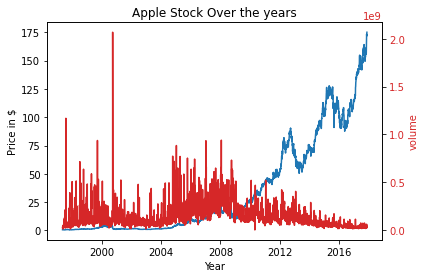

In [133]:
%matplotlib inline

x1 = np.array(pd_data1['Date'])
y1 = pd_data1['Open']
y12 = pd_data1['Volume']

plt.title("Apple Stock Over the years")
plt.xlabel('Year')
plt.ylabel("Price in $")

plt.plot(x1,y1)

ax2 =  plt.twinx()

color = 'tab:red'
ax2.set_ylabel('volume', color=color)
ax2.plot(x1, y12, color=color)
ax2.tick_params(axis='y', labelcolor=color)

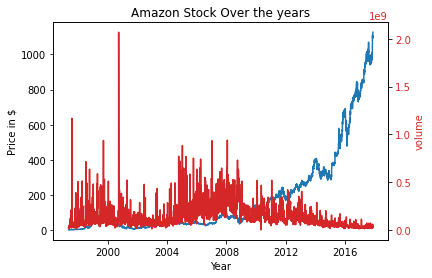

In [134]:
%matplotlib inline

x2 = np.array(pd_data2['Date'])
y2 = pd_data2['Open']
y22 = pd_data1['Volume']

plt.title("Amazon Stock Over the years")
plt.xlabel('Year')
plt.ylabel("Price in $")

plt.plot(x2,y2)

ax2 =  plt.twinx()

color = 'tab:red'
ax2.set_ylabel('volume', color=color)
ax2.plot(x2, y22, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()

In [135]:
pd_data1_train = pd_data1[0:training]
pd_data2_train = pd_data2[0:training]
pd_data1_test = pd_data1[training:training+test]
pd_data2_test = pd_data2[training:training+test]

In [136]:
vol1_train = getStockVolVec(stock_name1)
vol2_train = getStockVolVec(stock_name2)

In [137]:
total_Prof = []
done = False
Act_datasize = training
batch_size = 64

#Benchmark

data1_train = pd_data1_train['Open']
data2_train = pd_data2_train['Open']
data1_date = pd_data1_train['Date']


Act_Bench_Stock1_Bal = int(np.floor((start_balance/4)/data1_train[0]))
Act_Bench_Stock2_Bal = int(np.floor((start_balance/4)/data2_train[0]))
Act_Bench_Open_cash = start_balance/2

#Calculate Benchmark Profit

interval = int(Act_datasize/10)
print(interval)
Total_Stock1_Amount = 0
Total_Stock2_Amount = 0
stocks1Value = 0
stocks2Value = 0

Act_stocks1 = np.floor(Act_Bench_Stock1_Bal /10)
Act_stocks2 = np.floor(Act_Bench_Stock2_Bal /10)

remaining_stock1 = Act_Bench_Stock1_Bal
remaining_stock2 = Act_Bench_Stock2_Bal
ttl = 0

Benchmark_Port_Value = []

for j in range( interval, Act_datasize + 1, interval):
  Price_closing_Stock1 = data1_train[j-1]
  Price_closing_Stock2 = data2_train[j-1]

  date_stock1 = data1_date[j-1].strftime('%Y-%m-%d')
  stocks1Value = Act_stocks1 * Price_closing_Stock1
  stocks2Value = Act_stocks2 * Price_closing_Stock2
  remaining_stock1 = remaining_stock1-Act_stocks1
  remaining_stock2 = remaining_stock2-Act_stocks2

  Stock1_Port_value = remaining_stock1 * Price_closing_Stock1
  Stock2_Port_value = remaining_stock2 * Price_closing_Stock2
  Act_Bench_Open_cash  = Act_Bench_Open_cash + stocks1Value + stocks2Value
  #^ adds 10% sold value into open cash
  Total_Portfolio_value = Act_Bench_Open_cash + Stock1_Port_value + Stock2_Port_value
  Benchmark_Port_Value.append([date_stock1, Total_Portfolio_value])

Training_Benchmark_Portfolio_Value = Total_Portfolio_value

print("Benchmark_Profit is  " + str(Training_Benchmark_Portfolio_Value) +", with Apple Stocks:  " + str(remaining_stock1) + 
      " and Amazon stocks:  "+ str(remaining_stock2) )


150
Benchmark_Profit is  52655.37275, with Apple Stocks:  6.0 and Amazon stocks:  9.0


In [138]:
#Define arrays to store per episode values 
total_Prof=[]
total_stock1bal=[]
total_stock2bal=[]
total_open_cash=[]
total_port_value=[]
total_days_played=[]

In [139]:
#Training run

import csv


for e in range(episode_count + 1):
    print("..........")
    print("Episode " + str(e) + "/" + str(episode_count))
    
    Bal_stock1=int(np.floor((start_balance/4)/data1_train[0]))
    Bal_stock2=int(np.floor((start_balance/4)/data2_train[0]))
    open_cash=start_balance/2
    
    datasize=training
    done=False
    total_profit = 0
    reward = 0
    
    #Initialize Agent
    agent = Agent(8)
    agent.inventory1 =[]
    agent.inventory2 =[]
    for i in range(Bal_stock1):
        agent.inventory1.append(data1_train[0])
    for i in range(Bal_stock2):
        agent.inventory2.append(data2_train[0]) 
    
    
    #Timestep delta to make sure that with time reward increases for taking action
    #timestep_delta=0
    
    #Running episode over all days in the datasize
    for t in range(datasize):
        #print("..........")
        #print(pd_data1_train.iloc[t,0])
        state_class_obj= State(data1_train, data2_train, Bal_stock1, Bal_stock2, open_cash,t)
        state_array_obj=state_class_obj.getState()
        action = agent.act(state_array_obj)
         
                   
        change_percent_stock1=(state_class_obj.Stock1Price-state_class_obj.fiveday_stock1)/state_class_obj.fiveday_stock1*100
        change_percent_stock2=(state_class_obj.Stock2Price-state_class_obj.fiveday_stock2)/state_class_obj.fiveday_stock2*100
        
        #print("change_percent_stock1:  "+str(change_percent_stock1))
        #print("change_percent_stock2:  "+str(change_percent_stock2))
        
        
        if action == 0:  #buy stock 1
            if state_class_obj.Stock1Price > state_class_obj.open_cash:
                
                #If agent is trying to buy when it has no cash but has stock1 and stock2 balance then, 
                #it should pick from other actions
                #if (state_class_obj.Stock1Blnc>1) and  (state_class_obj.Stock2Blnc>1):
                 #   action=random.sample([1, 2, 4, 5, 6],  1)  # Choose 1 elements from sell actions
                #else:    
                #print("Bankrupt")
                reward=-200000
                done = True
                #end episode
                     
            else:
                #print("In Buy stock 1")
                agent.inventory1.append(data1_train[t])
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash-state_class_obj.Stock1Price #Here we are buying 1 stock
                
                #needs to be reviewed
                
                if(state_class_obj.open_cash<500):
                    reward=-100000
                elif (abs(change_percent_stock1)<=2):
                    reward=-10000
                else:  
                    reward=-change_percent_stock1*100
                

               
                
        if action == 1:  #sell stock 1
            if state_class_obj.Stock1Blnc <1 :
               # print("sold stock 2 when it did not have stock 2, so bankrupt, end of episode")
                reward=-200000
                done = True
                #end episode
            else:
                #print("In sell stock 1")
                bought_price1=agent.inventory1.pop(0)
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash+state_class_obj.Stock1Price #State[0] is the price of stock 1. Here we are buying 1 stock
          
                if(state_class_obj.Stock1Blnc<10):
                    reward=-100000
                elif (abs(change_percent_stock1)<=2):
                    reward=-10000
                else:
                    reward=change_percent_stock1*100 #State[0] is the price of stock 1. Here we are buying 1 stock
                
                
                
        


        
        if action == 2:             # Do nothing action    
                if (abs(change_percent_stock1)<=2) and (abs(change_percent_stock2)<=2):
                    reward=10000
                elif (state_class_obj.open_cash<0.1*start_balance):
                    reward=1000000
                elif (abs(change_percent_stock1)<=2) or (abs(change_percent_stock2)<=2):
                    reward=1000
                else:
                    reward=-100000
                
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=open_cash
               # print("Do nothing")
        
        
        if action == 3:  #buy stock 2
            if state_class_obj.Stock2Price > state_class_obj.open_cash:
                '''
                print("Buy stock 2 when it did not have cash, so bankrupt, end of episode")
                
                '''
                #If agent is trying to buy when it has no cash but has stock1 and stock2 balance then, 
                #it should pick from other actions
                #if (state_class_obj.Stock1Blnc>1) and  (state_class_obj.Stock2Blnc>1):
                 #   action=random.sample([1, 2, 4, 5, 6],  1)  # Choose 1 elements from sell actions
                #else:    
                #print("Bankrupt")
                reward=-200000
                done = True
                     #end episode   
            else:
                #print("In Buy stock 2")
                agent.inventory2.append(data2_train[t])
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash-state_class_obj.Stock2Price
                
                if(state_class_obj.open_cash<5000):
                    reward=-100000
                elif (abs(change_percent_stock2)<=2):
                    reward=-10000
                else:
                    reward=-change_percent_stock2*100
 
        
        if action == 4:  #sell stock 2
            if state_class_obj.Stock2Blnc <1 :
                    #print("sold stock 2 when it did not have stock 2, so bankrupt, end of episode")
                    reward=-200000
                    done = True
                #end episode
            else:
                #print("In sell stock 2")
                bought_price2=agent.inventory2.pop(0)
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash+state_class_obj.Stock2Price
    
              
                if(state_class_obj.Stock2Blnc<10):
                    reward=-100000
                elif (abs(change_percent_stock2)<=2):
                    reward=-10000
                else:
                    reward=change_percent_stock2*100 
                
                
                total_profit += state_class_obj.Stock2Price - bought_price2

              
            
        
        
        
        if t == datasize-1:
            #print("t==datasize")
            done=True
            next_state_class_obj=State(data1_train, data2_train, Bal_stock1_t1, Bal_stock2_t1, open_cash_t1,t)
            next_state_array_obj=next_state_class_obj.getState()
        else:
            next_state_class_obj=State(data1_train, data2_train, Bal_stock1_t1, Bal_stock2_t1, open_cash_t1,t+1)
            next_state_array_obj=next_state_class_obj.getState()
            
        agent.memory.append((state_array_obj, action, reward, next_state_array_obj, done))
      
         
        Bal_stock1=Bal_stock1_t1
        Bal_stock2= Bal_stock2_t1
        open_cash=open_cash_t1
        
        

       
        
        
        if done==True:

            total_Prof.append(total_profit)
            total_stock1bal.append(len(agent.inventory1))
            total_stock2bal.append(len(agent.inventory2))
            total_open_cash.append(state_class_obj.open_cash)
            total_port_value.append(state_class_obj.portfolio_value)
            total_days_played.append(t)


            print("--------------------------------")
            state_class_obj.reset(data1_train, data2_train, Bal_stock1, Bal_stock2, open_cash,t)
            break
           
          

        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)


    if e % 10 == 0:
        agent.model.save("/content/drive/MyDrive/IDS576/Project/models/model_ep" + str(e))


..........
Episode 0/51
--------------------------------
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IDS576/Project/models/model_ep0/assets
..........
Episode 1/51
--------------------------------
..........
Episode 2/51
--------------------------------
..........
Episode 3/51
--------------------------------
..........
Episode 4/51
--------------------------------
..........
Episode 5/51
--------------------------------
..........
Episode 6/51
--------------------------------
..........
Episode 7/51
--------------------------------
..........
Episode 8/51
--------------------------------
..........
Episode 9/51
--------------------------------
..........
Episode 10/51
--------------------------------
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IDS576/Project/models/model_ep10/assets
..........
Episode 11/51
--------------------------------
..........
Episode 12/51
--------------------------------
..........
Episode 13/51
--------------------------------
...

In [140]:
print("Total Apple stocks in episodes \n"+ str(total_stock1bal) + "\n")
print("Total Amazon stocks in episodes\n"+ str(total_stock2bal) + "\n")
print("Total Open cash in episodes\n"+ str(total_open_cash) + "\n")
print("Total Portfolio value in episodes\n"+ str(total_port_value) + "\n")
print("Total Days in episodes\n"+ str(total_days_played) + "\n")

print("Benchmark_Profit is  " + str(int(Training_Benchmark_Portfolio_Value)) +"   with remaining Apple Stocks: " + str(remaining_stock1) + 
      "   and remaining Amazon stocks: "+ str(remaining_stock2) )

Total Apple stocks in episodes 
[3247, 4437, 4463, 4469, 3494, 5681, 3210, 4453, 3204, 4455, 4441, 3720, 5690, 4497, 4457, 3215, 4455, 4450, 3246, 4460, 5709, 5658, 5681, 3681, 3223, 4442, 5699, 4444, 4458, 4449, 4440, 4449, 4449, 3840, 4448, 4519, 3400, 4424, 5319, 4448, 5274, 4434, 4453, 4197, 4470, 3205, 4462, 3536, 5677, 4993, 3207, 4461]

Total Amazon stocks in episodes
[1268, 1269, 1278, 1487, 1531, 1274, 1269, 1503, 1265, 1469, 1472, 757, 1260, 1266, 1495, 1246, 1480, 68, 1243, 1293, 1279, 1272, 1272, 848, 1264, 1484, 1272, 1490, 1340, 1477, 43, 45, 1279, 645, 1267, 1276, 1090, 1477, 872, 1276, 840, 1263, 1264, 1249, 36, 1282, 138, 1568, 1273, 1048, 1259, 1481]

Total Open cash in episodes
[7143.440019999987, 5295.389769999999, 4574.556879999999, 51.93752000000319, 308.6126600000038, 2994.457419999995, 6815.83238, 2.2992500000023313, 7226.641959999998, 27.734880000002732, 45.44204000000876, 16242.345659999983, 3097.0024400000066, 5029.944420000007, 49.440070000001725, 7176.76469

In [141]:
pd_data1_test=pd_data1_test.reset_index(drop=True)
pd_data2_test=pd_data2_test.reset_index(drop=True)

In [142]:
pd_data1_test.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2003-05-15,1.1910,1.2076,1.1820,1.1999,79866509,0
1,2003-05-16,1.1898,1.2167,1.1704,1.2037,94069639,0
2,2003-05-19,1.1871,1.1935,1.1563,1.1589,124591981,0
3,2003-05-20,1.1589,1.1628,1.1271,1.1385,116368335,0
4,2003-05-21,1.1385,1.1577,1.1320,1.1437,85352801,0


In [143]:
pd_data2_test.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2003-05-15,32.64,32.75,32.20,32.63,5222009,0
1,2003-05-16,32.51,33.16,32.38,33.05,7654816,0
2,2003-05-19,32.70,32.97,31.40,31.56,9798178,0
3,2003-05-20,31.56,32.13,31.17,31.48,8093492,0
4,2003-05-21,31.48,31.84,31.16,31.75,5217622,0


In [144]:
#Initialize state and set benchmarking model

import datetime

#print(df_data1)
total_Prof=[]
done=False

Act_datasize = test
batch_size = 64


#To be removed
#Sstart_balance=500

#Benchmark Model

# Take Opening price in a new variable
data1_test=pd_data1_test['Open']
data2_test=pd_data2_test['Open']

data1_date=pd_data1_test['Date']



Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_test[0]))
Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_test[0]))
Act_Bench_Open_cash=start_balance/2




### Program to calculate benchmark profit


#sell 10% of stock in 10 intervals

interval=int(Act_datasize/10)
Total_Stock1_Amount= 0
Total_Stock2_Amount= 0
stocks2Value = 0
stocks1Value = 0

Act_stocks1=np.floor(Act_Bench_Stock1_Bal /10)
Act_stocks2=np.floor(Act_Bench_Stock2_Bal /10)
#print(str(Act_stocks1))
#print(str(Act_stocks2))

remaining_stock1=Act_Bench_Stock1_Bal
remaining_stock2=Act_Bench_Stock2_Bal
ttl=0

Benchmark_Port_Value=[]


for j in range (interval,Act_datasize+1,interval):
        #print("closing prices : " + str(data1_test[j-1]) )
        Price_closing_Stock1=data1_test[j-1]
        Price_closing_Stock2=data2_test[j-1]
        date_stock1=data1_date[j-1].strftime('%Y-%m-%d')
        #print(date_stock1)
        #np.array(pd_data1_test['Date'])
        
        stocks1Value= Act_stocks1 * Price_closing_Stock1
        stocks2Value= Act_stocks2 * Price_closing_Stock2
        remaining_stock1=remaining_stock1-Act_stocks1
        remaining_stock2=remaining_stock2-Act_stocks2
        #print("J is:"+ str(j))
        
        
        
        Stock1_Port_value=remaining_stock1*Price_closing_Stock1
        Stock2_Port_value=remaining_stock2*Price_closing_Stock2
        Act_Bench_Open_cash=Act_Bench_Open_cash+stocks1Value+stocks2Value #Adding 10% sold value into open cash
        
        Total_Portfolio_value=Act_Bench_Open_cash+Stock1_Port_value+Stock2_Port_value
        Benchmark_Port_Value.append([date_stock1,Total_Portfolio_value])
        



#print ("total_Test_Benchmark_amount : " +  str(Total_Portfolio_value))

Test_Benchmark_Portfolio_Value = Total_Portfolio_value




print("Benchmark_Profit is " + str(Test_Benchmark_Portfolio_Value) +" with remaining Apple Stocks: " + str(remaining_stock1) + 
      " and remaining Amazon stocks: "+ str(remaining_stock2) )


#Define arrays to store per episode values 
total_Prof=[]
total_stock1bal=[]
total_stock2bal=[]
total_open_cash=[]
total_port_value=[]
total_days_played=[]


print(episode_count)


Benchmark_Profit is 13725.1903 with remaining Apple Stocks: 9.0 and remaining Amazon stocks: 6.0
51


In [145]:

#Actual run

import csv
episode_count=0


#Define arrays to store per episode values 
Act_total_Prof=[]
Act_total_stock1bal=[]
Act_total_stock2bal=[]
Act_total_open_cash=[]
Act_total_port_value=[]
Act_total_days_played=[]
actions_done_perday=[]
portfolio_value=[]

from keras.models import load_model

model_name='model_ep50'

model = load_model("/content/drive/MyDrive/IDS576/Project/models/" + model_name)

initial_cash = state_class_obj.portfolio_value

print(initial_cash)

for e in range(1): #here we run only for 1 episode, as it is Test run

    Bal_stock1_t2=Act_Bench_Stock1_Bal
    Bal_stock2_t2=Act_Bench_Stock2_Bal
    done=False
    open_cash_t2= Act_Bench_Open_cash  
    total_profit = 0
    reward = 0
    
    #Initialize Agent
    agent_test = Agent(8, is_eval=True, model_name=model_name)
    #agent = Agent(8)

    agent_test.inventory1 =[]
    agent_test.inventory2 =[]
    for i in range(Bal_stock1_t2):
        agent_test.inventory1.append(data1_test[0])
    for i in range(Bal_stock2_t2):
        agent_test.inventory2.append(data2_test[0]) 
    
    
    #Timestep delta to make sure that with time reward increases for taking action
    timestep_delta=0
    
    #Running episode over all days in the datasize
    for t in range(Act_datasize):
        print("..........")
        
        print(pd_data1_test.iloc[t,0])
        state_class_obj= State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t)
        state_array_obj=state_class_obj.getState()
        action = agent_test.act(state_array_obj)
        
        print("Total portfolio value: " + str(state_class_obj.portfolio_value)+ 
                  "  stock 1 number: " + str(len(agent_test.inventory1))
                   +"  stock 2 number: "+str(len(agent_test.inventory2))+"  open cash"+str(state_class_obj.open_cash))


        
        #reward should be more as time goes further. We will remove reward_timedelta from actual reward 
        #reward_timedelta=(datasize-t)*timestep_delta
        
                   
        change_percent_stock1=(state_class_obj.Stock1Price-state_class_obj.fiveday_stock1)/state_class_obj.fiveday_stock1*100
        change_percent_stock2=(state_class_obj.Stock2Price-state_class_obj.fiveday_stock2)/state_class_obj.fiveday_stock2*100
        
        
        
        
        if action == 0:  #buy stock 1
            if state_class_obj.Stock1Price > state_class_obj.open_cash:
                '''
                print("Buy stock 1 when it did not have cash, so bankrupt, end of episode")
                reward=-reward_timedelta*10
                done = True
                '''
                #If agent is trying to buy when it has no cash but has stock1 and stock2 balance then, 
                #it should pick from other actions
                #if (state_class_obj.Stock1Blnc>1) and  (state_class_obj.Stock2Blnc>1):
                 #   action=random.sample([1, 2, 4, 5, 6],  1)  # Choose 1 elements from sell actions
                #else:    
                #print("Bankrupt")
              
                done = True
                #end episode
                     
            else:
                #print("In Buy stock 1")
                agent_test.inventory1.append(data1_test[t])
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash-state_class_obj.Stock1Price #Here we are buying 1 stock
                
                
               
                
        if action == 1:  #sell stock 1
            if state_class_obj.Stock1Blnc <1 :
               # print("sold stock 2 when it did not have stock 2, so bankrupt, end of episode")
                
                done = True
                #end episode
            else:
                #print("In sell stock 1")
                agent_test.inventory1.pop(0)

                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash+state_class_obj.Stock1Price #State[0] is the price of stock 1. Here we are buying 1 stoc
          
                 
        


        
        if action == 2:             # Do nothing action    
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
               # print("Do nothing")
        
        
        if action == 3:  #buy stock 2
            if state_class_obj.Stock2Price > state_class_obj.open_cash:
                '''
                print("Buy stock 2 when it did not have cash, so bankrupt, end of episode")
                reward=-reward_timedelta*10
                done = True
                
                '''
                #If agent is trying to buy when it has no cash but has stock1 and stock2 balance then, 
                #it should pick from other actions
                #if (state_class_obj.Stock1Blnc>1) and  (state_class_obj.Stock2Blnc>1):
                 #   action=random.sample([1, 2, 4, 5, 6],  1)  # Choose 1 elements from sell actions
                #else:    
                #print("Bankrupt")

                done = True
                     #end episode   
            else:
                #print("In Buy stock 2")
                agent.inventory2.append(data2_test[t])
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash-state_class_obj.Stock2Price
                
              
        
        if action == 4:  #sell stock 2
            if state_class_obj.Stock2Blnc <1 :
                    #print("sold stock 2 when it did not have stock 2, so bankrupt, end of episode")
                    done = True
                #end episode
            else:
                #print("In sell stock 2")
                agent_test.inventory2.pop(0)
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash+state_class_obj.Stock2Price
    

              
            
        
        
        
        if t == Act_datasize-1:
            
            done=True
            next_state_class_obj=State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t)
            next_state_array_obj=next_state_class_obj.getState()
        else:
            
            next_state_class_obj=State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t+1)
            next_state_array_obj=next_state_class_obj.getState()
            
        


       
        
        actions_done_perday.append(action)
        portfolio_value.append(next_state_class_obj.portfolio_value)

        if done==True:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(next_state_class_obj.portfolio_value - initial_cash))
            print("Total No. of days played: " + str(t)+ "  out of overall days:  " + str(Act_datasize))
            print("Total portfolio value: " + str(next_state_class_obj.portfolio_value)+ 
                  "  stock 1 number: " + str(len(agent_test.inventory1))
                   +"  stock 2 number: "+str(len(agent_test.inventory2))+"  open cash"+str(next_state_class_obj.open_cash))

            Act_total_Prof.append(total_profit)
            Act_total_stock1bal.append(len(agent_test.inventory1))
            Act_total_stock2bal.append(len(agent_test.inventory2))
            Act_total_open_cash.append(state_class_obj.open_cash)
            Act_total_port_value.append(state_class_obj.portfolio_value)
            Act_total_days_played.append(t)


            print("--------------------------------")
            state_class_obj.reset(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t)
            break



10000
..........
2003-05-15 00:00:00
Total portfolio value: 11718.5615  stock 1 number: 2099  stock 2 number: 76  open cash13476.025000000001
..........
2003-05-16 00:00:00
Total portfolio value: 11705.5684  stock 1 number: 2098  stock 2 number: 76  open cash13477.216000000002
..........
2003-05-19 00:00:00
Total portfolio value: 11713.751600000001  stock 1 number: 2097  stock 2 number: 76  open cash13478.405800000002
..........
2003-05-20 00:00:00
Total portfolio value: 11567.41085  stock 1 number: 2096  stock 2 number: 76  open cash13479.592900000001
..........
2003-05-21 00:00:00
Total portfolio value: 11518.013400000002  stock 1 number: 2095  stock 2 number: 76  open cash13480.751800000002
..........
2003-05-22 00:00:00
Total portfolio value: 11554.087950000001  stock 1 number: 2094  stock 2 number: 76  open cash13481.890300000001
..........
2003-05-23 00:00:00
Total portfolio value: 11693.70135  stock 1 number: 2093  stock 2 number: 76  open cash13483.0365
..........
2003-05-27 00

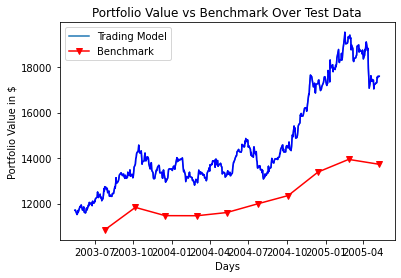

In [146]:
# Test Stock Prices and actions taken by agent Stock Plot
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline

pd_bm=pd.DataFrame.from_records(Benchmark_Port_Value)
pd_bm[0]=pd.to_datetime(pd_bm[0], format='%Y/%m/%d')

x1 = np.array(pd_data1_test['Date'])
y1 = portfolio_value

x2=pd_bm[0]
y2=pd_bm[1]



plt.title("Portfolio Value vs Benchmark Over Test Data")
plt.xlabel("Days")
plt.ylabel("Portfolio Value in $")

plt.plot(x1,y1)
plt.plot_date(x2, y2, c = 'red', marker='v', linestyle='-')


#plt.plot(x1, z, '-', color='black');
plt.plot(x1, y1, '-', color='blue');



#plt.scatter(x1,Benchmark_Port_Value,marker='o')

plt.legend(('Trading Model', 'Benchmark'))

plt.show()